# Week 4: Multi-class Classification

Welcome to this assignment! In this exercise, you will get a chance to work on a multi-class classification problem. You will be using the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the English alphabet.

You will need to pre-process the data so that it can be fed into your convolutional neural network to correctly classify each image as the letter it represents.


Let's get started!

In [1]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets (the test set will actually be used as a validation set):

In [2]:
!pip install gdown==5.1.0

In [3]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 106MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 88.8MB/s]


Define some globals with the path to both files you just downloaded:

In [4]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

In [5]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

As you can see, each file includes a header (the first line) and each subsequent data point is represented as a line that contains 785 values.

The first value is the label (the numeric representation of each letter) and the other 784 values are the value of each pixel of the image. Remember that the original images have a resolution of 28x28, which sums up to 784 pixels.

In [26]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file

  Args:
    filename (string): path to the CSV file

  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    # Use csv.reader, passing in the appropriate delimiter
    # Remember that csv.reader can be iterated and returns one line in each iteration
    csv_reader = csv.reader(file, delimiter=',')

    labels = []
    images = []

    # Skip header
    next(csv_reader, None)

    for row in csv_reader:
      label = row[0]
      image = row[1:]
      image = np.reshape(image, (28, 28))

      labels.append(label)
      images.append(image)

    labels = np.array(labels).astype('float64')
    images = np.array(images).astype('float64')
    
    return images, labels

In [27]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays

Now that you have converted the initial csv data into a format that is compatible with computer vision tasks, take a moment to actually see how the images of the dataset look like:

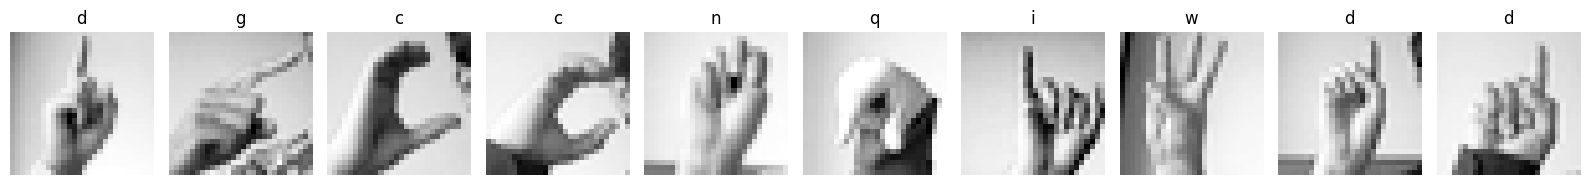

In [28]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

It is time for you to code the generators that will yield batches of images, both for training and validation. For this complete the `train_val_generators` function below.

In [29]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  # Add another dimension to the data
  training_images = np.expand_dims(training_images, axis = -1)
  validation_images = np.expand_dims(validation_images, axis = -1)

  # Instantiate the ImageDataGenerator class
  # normalize pixel values and set arguments to augment the images
  train_datagen = ImageDataGenerator(
      rescale = 1./255.,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
      )


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)


  # Instantiate the ImageDataGenerator class
  # Validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32)

  return train_generator, validation_generator

In [30]:
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN

One last step before training is to define the architecture of the model.

This function should return a Keras' model that uses the `Sequential` or the `Functional` API.

The last layer of the model should have a number of units equal to the number of letters in the English alphabet.

In [31]:
def create_model():

  # Define the model
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # 26 classes
    tf.keras.layers.Dense(26, activation='softmax')
  ])


  model.compile(optimizer = tf.optimizers.Adam(),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [32]:
# Save the model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 19s 17ms/step - loss: 2.6270 - accuracy: 0.1946 - val_loss: 1.6233 - val_accuracy: 0.4594
Epoch 2/15
858/858 [==============================] - 15s 17ms/step - loss: 1.7354 - accuracy: 0.4420 - val_loss: 1.0372 - val_accuracy: 0.6318
Epoch 3/15
858/858 [==============================] - 14s 16ms/step - loss: 1.2992 - accuracy: 0.5714 - val_loss: 0.7202 - val_accuracy: 0.7672
Epoch 4/15
858/858 [==============================] - 15s 17ms/step - loss: 1.0528 - accuracy: 0.6472 - val_loss: 0.5619 - val_accuracy: 0.8009
Epoch 5/15
858/858 [==============================] - 14s 16ms/step - loss: 0.8682 - accuracy: 0.7072 - val_loss: 0.5096 - val_accuracy: 0.8245
Epoch 6/15
858/858 [==============================] - 15s 17ms/step - loss: 0.7621 - accuracy: 0.7467 - val_loss: 0.3593 - val_accuracy: 0.8674
Epoch 7/15
858/858 [==============================] - 14s 16ms/step - loss: 0.6640 - accuracy: 0.7779 - val_loss: 0.3554 - val_accuracy:

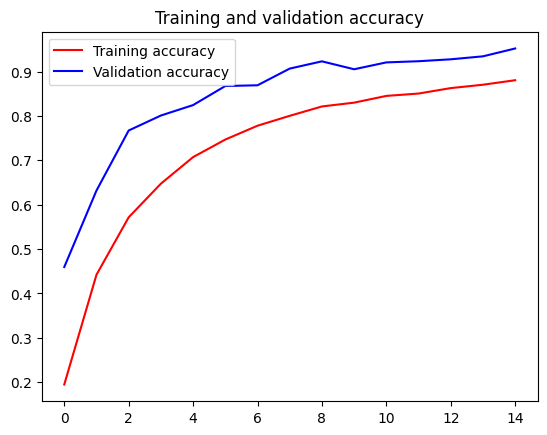

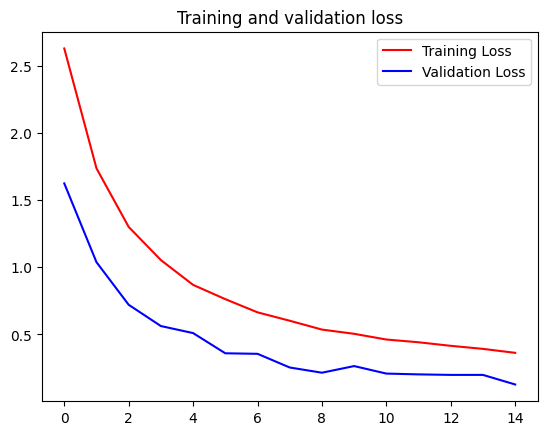

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()